# Frequency Analysis – Lab Report (ELA24)

**Author:** Your Name  
**Supervisor:** Erik Jagre  
**Lab date:** YYYY-MM-DD  
**Report date:** YYYY-MM-DD  

## Abstract
The aim of this laboratory is to investigate Fourier series representations of periodic signals and to analyze their harmonic content experimentally using an oscilloscope FFT. Theoretical harmonic amplitudes of sawtooth, triangle, and sine waves are compared to measured spectra. Furthermore, the influence of an RC low-pass filter on both amplitude and phase is studied in frequency and time domains. Results show good agreement with theory, with discrepancies explained by FFT resolution, noise, and practical measurement limitations.

## 1. Introduction
A central concept in signal processing is that signals can be represented both in the time domain and in the frequency domain. Fourier series allow us to express a periodic signal as a sum of sinusoidal components. The sharper the edges in the time domain, the slower the decay of harmonic amplitudes. This experiment provides hands-on experience with Fourier analysis of canonical signals.

### Key formulas (from course compendium & lab guidance)

- **Sawtooth (all harmonics):**  
  $$
  A_n = \frac{2A}{\pi n}, \quad n \geq 1
  $$

- **Triangle (odd harmonics only):**  
  $$
  A_n = \frac{8A}{\pi^2 n^2}, \quad n = 1,3,5,\dots
  $$

- **Sine:**  
  $$
  A_1 = A, \quad A_{n>1} = 0
  $$

- **RMS and dBV:**  
  $$
  V_{\mathrm{rms}} = \frac{V_{\mathrm{peak}}}{\sqrt{2}}, 
  \quad \mathrm{dBV} = 20 \log_{10}\!\left(\frac{V_{\mathrm{rms}}}{1~\mathrm{V}}\right)
  $$

- **RC low-pass transfer function:**  
  $$
  |H(f)| = \frac{1}{\sqrt{1 + (f/f_c)^2}}, 
  \quad \angle H(f) = -\arctan\!\bigl(f/f_c\bigr), 
  \quad f_c = \frac{1}{2\pi RC}
  $$

> **Note:** Theoretical values shown in tables and plots are computed directly from these expressions.


## 2. Experiment

### Equipment
- Signal generator: 1 kHz, **5 Vpp** (as in lab-PM), 0 V DC offset.  
- Oscilloscope: Keysight/Tektronix (FFT mode, Hann window, output in dBVrms).  
- RC filter:  
  $$
  R = 8.2\,\text{k}\Omega, \quad C = 10\,\text{nF}
  $$
  The cutoff frequency is  
  $$
  f_c = \frac{1}{2\pi RC} \approx 1.94~\text{kHz}
  $$
- Software: Python (NumPy, Pandas, Matplotlib).

### Procedure
1. Measure first 10 harmonics of **sawtooth** (1–10 kHz) using FFT.  
2. Repeat for **triangle** (expect odd harmonics only).  
3. Repeat for **sine** (expect only the fundamental).  
4. Insert **RC filter** and measure the sawtooth harmonics at the filter output.  
5. Observe the **time-domain effect** of filtering.  
6. Compare measurements to theoretical Fourier coefficients and RC transfer function.


In [58]:
# 3. Imports and global parameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

F0 = 1000.0    # fundamental frequency [Hz]
VPP = 5.0      # generator amplitude per Lab-PM (5 Vpp)
A = VPP / 2    # peak amplitude [V]
N_HARM = 10    # number of harmonics
R, C = 8200.0, 10e-9  # RC filter values
FC = 1.0 / (2 * np.pi * R * C)  # cutoff frequency

print(f"Cutoff frequency fc ≈ {FC:.2f} Hz")


Cutoff frequency fc ≈ 1940.91 Hz


## 3. Theory – Fourier coefficients (tables & per-signal plots)

In [59]:
# Fourier coefficient functions and conversion using **Vrms** (matches Keysight dBVrms)

import numpy as np
import pandas as pd

# --- Harmonic amplitudes in Vrms (no peaks used) ---

def sawtooth_vrms(n, A=A):
    """Vrms of nth harmonic for a sawtooth wave."""
    if n <= 0:
        return 0.0
    v_peak = 2 * A / (np.pi * n)
    return v_peak / np.sqrt(2)

def triangle_vrms(n, A=A):
    """Vrms of nth harmonic for a triangle wave (odd n only)."""
    if n <= 0 or (n % 2 == 0):
        return 0.0
    v_peak = 8 * A / (np.pi**2 * n**2)
    return v_peak / np.sqrt(2)

def sine_vrms(n, A=A):
    """Vrms of nth harmonic for an ideal sine (only n=1)."""
    if n == 1:
        return A / np.sqrt(2)
    return 0.0

def vrms_to_dBV(vrms, zero_as='-inf'):
    """
    Convert Vrms to dBV (0 dBV = 1.000 Vrms).
    zero_as: '-inf' | 'nan' | 'floor'
    """
    if vrms <= 0:
        if zero_as == '-inf':
            return -np.inf
        elif zero_as == 'nan':
            return np.nan
        else:  # 'floor'
            vrms = 1e-12
    return 20 * np.log10(vrms)

def to_dBc(dBV_array):
    """Convert absolute dBV spectrum to dBc vs the fundamental (index n=1)."""
    base = dBV_array[0]
    return dBV_array - base

# Harmonic indices
n = np.arange(1, N_HARM + 1)

# Vrms values per harmonic
saw_Vrms = np.array([sawtooth_vrms(k) for k in n])
tri_Vrms = np.array([triangle_vrms(k) for k in n])
sin_Vrms = np.array([sine_vrms(k) for k in n])

# Convert to dBV (absolute, Vrms-referenced) and dBc (relative to fundamental)
saw_dBV = np.array([vrms_to_dBV(v) for v in saw_Vrms])
tri_dBV = np.array([vrms_to_dBV(v) for v in tri_Vrms])
sin_dBV = np.array([vrms_to_dBV(v) for v in sin_Vrms])

saw_dBc = to_dBc(saw_dBV)
tri_dBc = to_dBc(tri_dBV)
sin_dBc = to_dBc(sin_dBV)

# Collect into DataFrame (include Vrms columns for direct scope comparison)
df_theory = pd.DataFrame({
    'n': n,
    'f_Hz': n * F0,
    'Sawtooth_Vrms': saw_Vrms,
    'Sawtooth_dBV': saw_dBV,
    'Sawtooth_dBc': saw_dBc,
    'Triangle_Vrms': tri_Vrms,
    'Triangle_dBV': tri_dBV,
    'Triangle_dBc': tri_dBc,
    'Sine_Vrms': sin_Vrms,
    'Sine_dBV': sin_dBV,
    'Sine_dBc': sin_dBc
})

# Sanity-check printout for 5 Vpp input
print("Expected fundamentals @ 5 Vpp input (Vrms & dBV):")
print(f"Sine:     {sin_Vrms[0]:.4f} Vrms  /  {sin_dBV[0]:.2f} dBV   (≈ 1.767 Vrms / +4.95 dBV)")
print(f"Sawtooth: {saw_Vrms[0]:.4f} Vrms  /  {saw_dBV[0]:.2f} dBV   (≈ 1.126 Vrms / +1.03 dBV)")
print(f"Triangle: {tri_Vrms[0]:.4f} Vrms  /  {tri_dBV[0]:.2f} dBV   (≈ 1.432 Vrms / +3.12 dBV)")

df_theory


Expected fundamentals @ 5 Vpp input (Vrms & dBV):
Sine:     1.7678 Vrms  /  4.95 dBV   (≈ 1.767 Vrms / +4.95 dBV)
Sawtooth: 1.1254 Vrms  /  1.03 dBV   (≈ 1.126 Vrms / +1.03 dBV)
Triangle: 1.4329 Vrms  /  3.12 dBV   (≈ 1.432 Vrms / +3.12 dBV)


,n,f_Hz,Sawtooth_Vrms,Sawtooth_dBV,Sawtooth_dBc,Triangle_Vrms,Triangle_dBV,Triangle_dBc,Sine_Vrms,Sine_dBV,Sine_dBc
0,1,1000.0,1.125395,1.026103,0.000000,1.432898,3.124305,0.000000,1.767767,4.9485,0.0
1,2,2000.0,0.562698,-4.994497,-6.020600,0.000000,-inf,-inf,0.000000,-inf,-inf
2,3,3000.0,0.375132,-8.516322,-9.542425,0.159211,-15.960545,-19.084850,0.000000,-inf,-inf
3,4,4000.0,0.281349,-11.015097,-12.041200,0.000000,-inf,-inf,0.000000,-inf,-inf
4,5,5000.0,0.225079,-12.953297,-13.979400,0.057316,-24.834495,-27.958800,0.000000,-inf,-inf
5,6,6000.0,0.187566,-14.536922,-15.563025,0.000000,-inf,-inf,0.000000,-inf,-inf
6,7,7000.0,0.160771,-15.875858,-16.901961,0.029243,-30.679617,-33.803922,0.000000,-inf,-inf
7,8,8000.0,0.140674,-17.035697,-18.061800,0.000000,-inf,-inf,0.000000,-inf,-inf
8,9,9000.0,0.125044,-18.058748,-19.084850,0.017690,-35.045395,-38.169700,0.000000,-inf,-inf
9,10,10000.0,0.112540,-18.973897,-20.000000,0.000000,-inf,-inf,0.000000,-inf,-inf


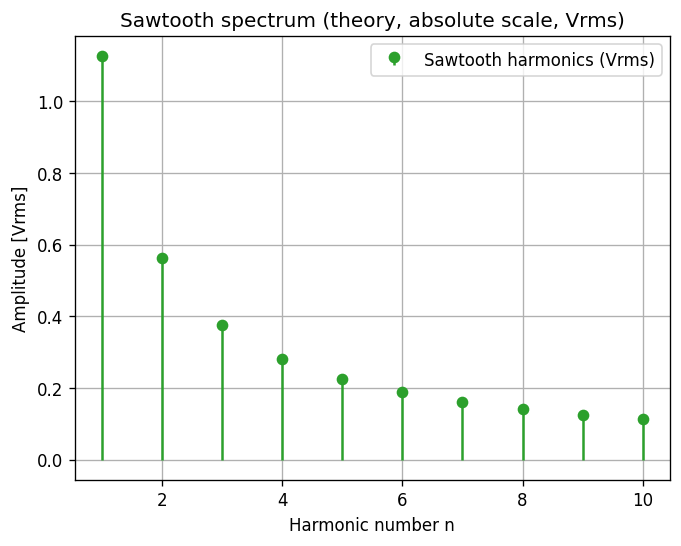

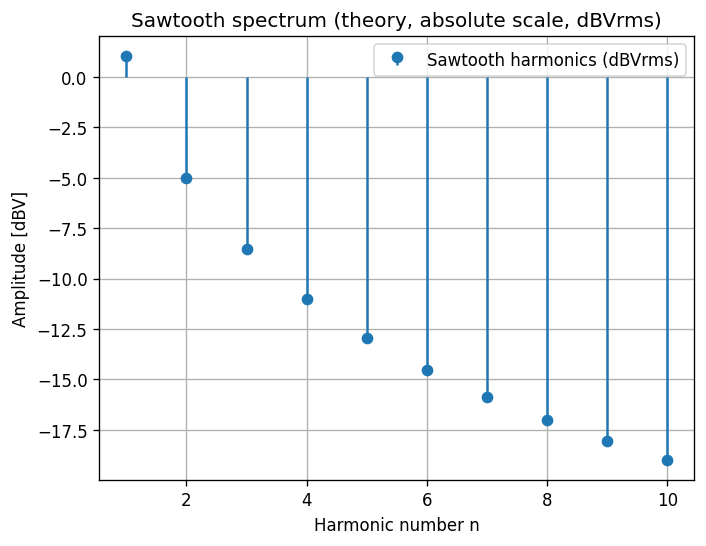

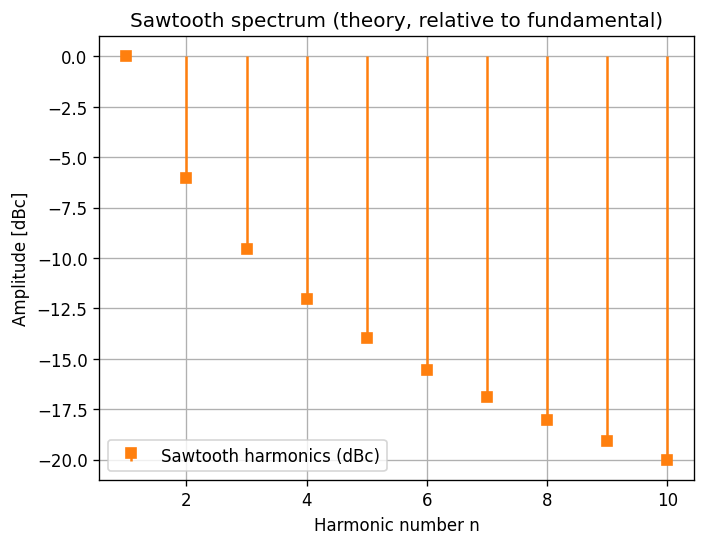

In [60]:
# Sawtooth theoretical spectrum (Vrms, dBVrms absolute, and dBc)

import matplotlib.pyplot as plt

# --- Linear scale (Vrms) ---
plt.figure()
plt.stem(n, saw_Vrms,
         linefmt='C2-', markerfmt='C2o', basefmt=" ",
         label='Sawtooth harmonics (Vrms)')
plt.xlabel('Harmonic number n')
plt.ylabel('Amplitude [Vrms]')
plt.title('Sawtooth spectrum (theory, absolute scale, Vrms)')
plt.grid(True)
plt.legend()
plt.show()

# --- Absolute scale (dBVrms) ---
plt.figure()
plt.stem(n, saw_dBV,
         linefmt='C0-', markerfmt='C0o', basefmt=" ",
         label='Sawtooth harmonics (dBVrms)')
plt.xlabel('Harmonic number n')
plt.ylabel('Amplitude [dBV]')
plt.title('Sawtooth spectrum (theory, absolute scale, dBVrms)')
plt.grid(True)
plt.legend()
plt.show()

# --- Relative scale (dBc vs fundamental) ---
plt.figure()
plt.stem(n, saw_dBc,
         linefmt='C1-', markerfmt='C1s', basefmt=" ",
         label='Sawtooth harmonics (dBc)')
plt.xlabel('Harmonic number n')
plt.ylabel('Amplitude [dBc]')
plt.title('Sawtooth spectrum (theory, relative to fundamental)')
plt.grid(True)
plt.legend()
plt.show()


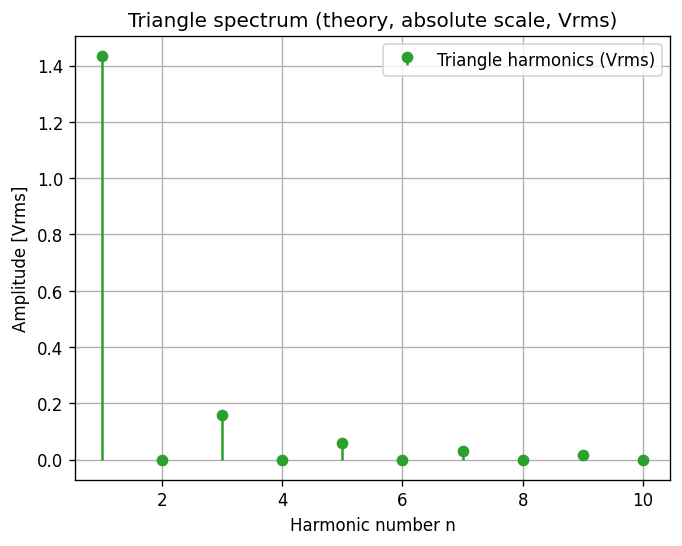

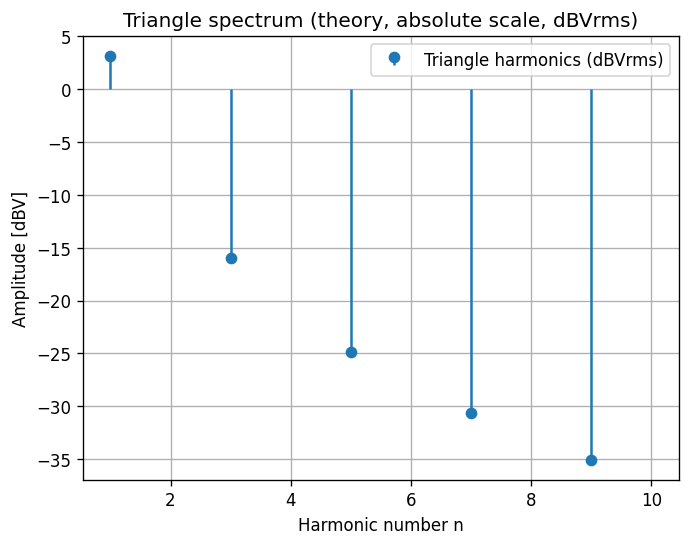

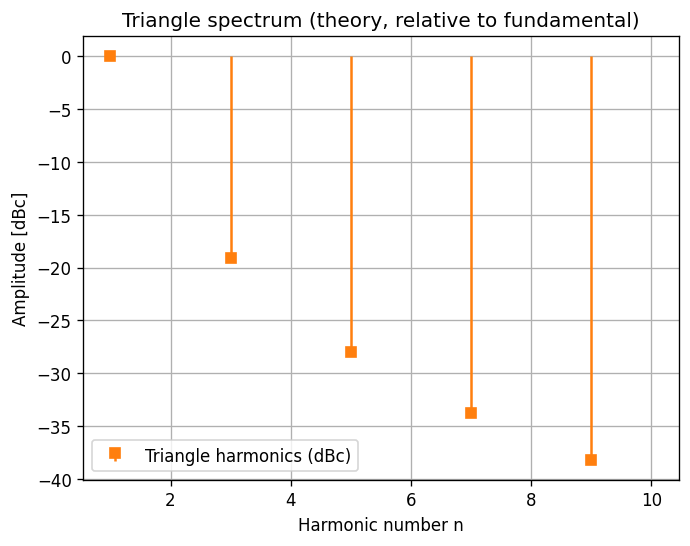

In [61]:
# Triangle theoretical spectrum (Vrms, dBVrms absolute, and dBc)

# --- Linear scale (Vrms) ---
plt.figure()
plt.stem(n, tri_Vrms,
         linefmt='C2-', markerfmt='C2o', basefmt=" ",
         label='Triangle harmonics (Vrms)')
plt.xlabel('Harmonic number n')
plt.ylabel('Amplitude [Vrms]')
plt.title('Triangle spectrum (theory, absolute scale, Vrms)')
plt.grid(True)
plt.legend()
plt.show()

# --- Absolute scale (dBVrms) ---
plt.figure()
plt.stem(n, tri_dBV,
         linefmt='C0-', markerfmt='C0o', basefmt=" ",
         label='Triangle harmonics (dBVrms)')
plt.xlabel('Harmonic number n')
plt.ylabel('Amplitude [dBV]')
plt.title('Triangle spectrum (theory, absolute scale, dBVrms)')
plt.grid(True)
plt.legend()
plt.show()

# --- Relative scale (dBc vs fundamental) ---
plt.figure()
plt.stem(n, tri_dBc,
         linefmt='C1-', markerfmt='C1s', basefmt=" ",
         label='Triangle harmonics (dBc)')
plt.xlabel('Harmonic number n')
plt.ylabel('Amplitude [dBc]')
plt.title('Triangle spectrum (theory, relative to fundamental)')
plt.grid(True)
plt.legend()
plt.show()


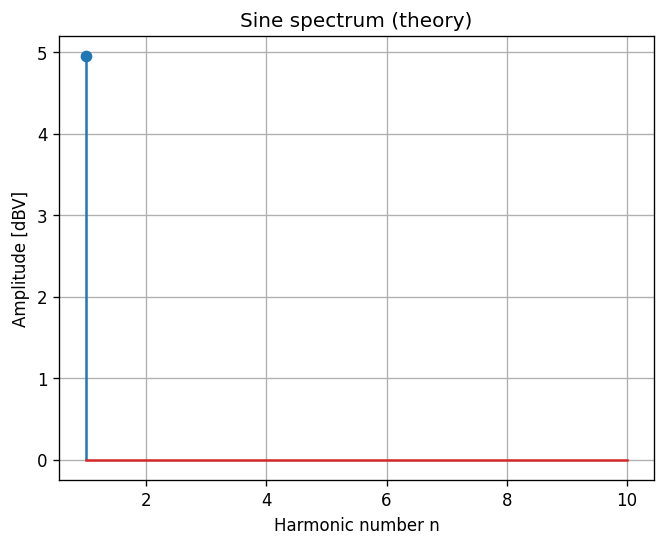

In [62]:
# Sine theoretical spectrum
plt.figure()
plt.stem(n, sin_dBV)
plt.xlabel('Harmonic number n')
plt.ylabel('Amplitude [dBV]')
plt.title('Sine spectrum (theory)')
plt.grid(True)
plt.show()


## 4. Theory – RC filter response (table & predicted spectra)

In [63]:
def rc_mag(f, fc=FC):
    return 1.0/np.sqrt(1.0+(f/fc)**2)
def rc_phase_deg(f, fc=FC):
    return -np.degrees(np.arctan(f/fc))

f_harm = n*F0
H_mag = rc_mag(f_harm)
H_dB = 20*np.log10(np.maximum(H_mag, 1e-15))
H_phase = rc_phase_deg(f_harm)

df_rc = pd.DataFrame({'n': n, 'f_Hz': f_harm, 'RC_atten_dB': H_dB, 'RC_phase_deg': H_phase})
df_rc

,n,f_Hz,RC_atten_dB,RC_phase_deg
0,1,1000.0,-1.022460,-27.258483
1,2,2000.0,-3.142490,-45.858970
2,3,3000.0,-5.300813,-57.098291
3,4,4000.0,-7.199314,-64.116017
4,5,5000.0,-8.828842,-68.784645
5,6,6000.0,-10.235119,-72.074350
6,7,7000.0,-11.463511,-74.502720
7,8,8000.0,-12.550066,-76.362724
8,9,9000.0,-13.522150,-77.830139
9,10,10000.0,-14.400473,-79.015952


|H(1 kHz)| ≈ 0.889;  Saw n=1 after RC ≈ 1.000 Vrms  (0.00 dBV)


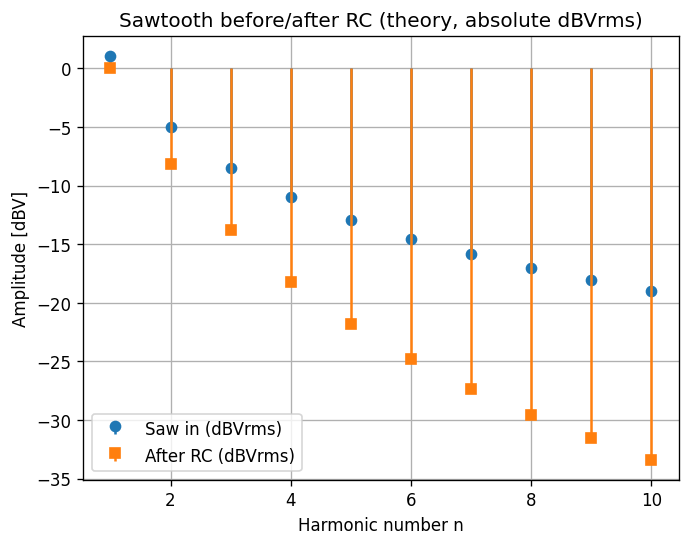

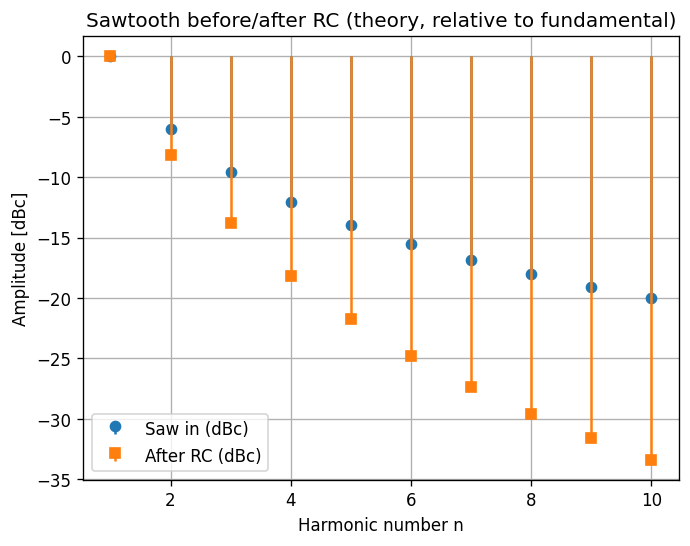

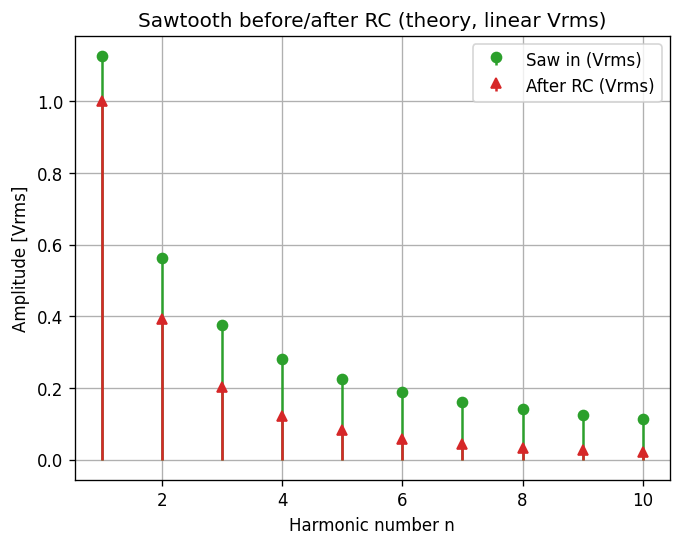

In [64]:
# Predicted filtered sawtooth using |H|, computed in Vrms (Keysight-friendly)

# 1) RC magnitude at each harmonic
def rc_mag(f, fc=FC):
    return 1.0 / np.sqrt(1.0 + (f/fc)**2)

f_harm = n * F0
H_mag  = rc_mag(f_harm)

# 2) Apply filter to Vrms spectrum (linear domain)
saw_filt_Vrms = saw_Vrms * H_mag

# 3) Convert to dBVrms and dBc
def vrms_to_dBV(vrms, zero_as='-inf'):
    if vrms <= 0:
        return -np.inf if zero_as == '-inf' else np.nan
    return 20*np.log10(vrms)

saw_filt_dBV = np.array([vrms_to_dBV(v) for v in saw_filt_Vrms])
saw_filt_dBc = saw_filt_dBV - saw_filt_dBV[0]

# --- Optional quick sanity check at 1 kHz ---
print(f"|H(1 kHz)| ≈ {H_mag[0]:.3f};  Saw n=1 after RC ≈ {saw_filt_Vrms[0]:.3f} Vrms  "
      f"({saw_filt_dBV[0]:.2f} dBV)")

# 4) Plots

# Absolute scale (dBVrms)
plt.figure()
plt.stem(n, saw_dBV,        linefmt='C0-', markerfmt='C0o', basefmt=" ", label='Saw in (dBVrms)')
plt.stem(n, saw_filt_dBV,   linefmt='C1-', markerfmt='C1s', basefmt=" ", label='After RC (dBVrms)')
plt.xlabel('Harmonic number n')
plt.ylabel('Amplitude [dBV]')
plt.title('Sawtooth before/after RC (theory, absolute dBVrms)')
plt.grid(True)
plt.legend()
plt.show()

# Relative scale (dBc w.r.t. each fundamental)
plt.figure()
plt.stem(n, saw_dBc,        linefmt='C0-', markerfmt='C0o', basefmt=" ", label='Saw in (dBc)')
plt.stem(n, saw_filt_dBc,   linefmt='C1-', markerfmt='C1s', basefmt=" ", label='After RC (dBc)')
plt.xlabel('Harmonic number n')
plt.ylabel('Amplitude [dBc]')
plt.title('Sawtooth before/after RC (theory, relative to fundamental)')
plt.grid(True)
plt.legend()
plt.show()

# (Optional) Also show Vrms directly for the report table
plt.figure()
plt.stem(n, saw_Vrms,      linefmt='C2-', markerfmt='C2o', basefmt=" ", label='Saw in (Vrms)')
plt.stem(n, saw_filt_Vrms, linefmt='C3-', markerfmt='C3^', basefmt=" ", label='After RC (Vrms)')
plt.xlabel('Harmonic number n')
plt.ylabel('Amplitude [Vrms]')
plt.title('Sawtooth before/after RC (theory, linear Vrms)')
plt.grid(True)
plt.legend()
plt.show()


In [65]:
# === Robust reader for Keysight raw FFT CSV (semicolon + decimal comma + leading empty fields) ===
# It extracts the last two numeric entries per row as [freq_Hz, Vrms], builds a clean spectrum,
# then runs the harmonic comparison (Vrms, dBV, dBc) vs theory, with safety guards.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.dpi'] = 120

# ----- Lab params -----
F0      = 1000.0
VPP     = 5.0
A       = VPP/2
N_HARM  = 10
R, C    = 8200.0, 10e-9
FC      = 1.0/(2*np.pi*R*C)

# ----- Theory helpers (Vrms) -----
def sawtooth_vrms(n, A=A):
    if n <= 0: return 0.0
    vpk = 2*A/(np.pi*n)
    return vpk/np.sqrt(2)

def triangle_vrms(n, A=A):
    if n <= 0 or (n % 2 == 0): return 0.0
    vpk = 8*A/(np.pi**2*n**2)
    return vpk/np.sqrt(2)

def sine_vrms(n, A=A):
    return A/np.sqrt(2) if n == 1 else 0.0

def vrms_to_dBV(vrms):
    return 20*np.log10(np.maximum(vrms, 1e-15))

def to_dBc(dBV_array):
    base = dBV_array[0]
    return dBV_array - base

def rc_mag(f, fc=FC):
    return 1.0/np.sqrt(1.0+(f/fc)**2)

# ----- NEW robust parser for your raw CSV lines like ";;;49,59;0,00058;" -----
def read_keysight_raw_fft(csv_path):
    """
    Accepts a *raw* Keysight export that may contain metadata rows and rows like:
      ;;;49,591064432;0,000585967223742045;
    Returns a clean DataFrame with columns: freq [Hz], Vrms, dBV
    Assumes magnitudes are Vrms (as you stated).
    """
    csv_path = Path(csv_path)
    # Read all cells as strings; we’ll coerce to numerics ourselves
    raw = pd.read_csv(csv_path, sep=';', header=None, engine='python', dtype=str)

    freqs = []
    mags  = []
    # Iterate rows; for each row, parse comma-decimal numbers; keep the last two numbers as [freq, Vrms]
    for _, row in raw.iterrows():
        nums = []
        for cell in row.dropna().tolist():
            s = cell.strip()
            if not s:
                continue
            # Replace decimal comma
            s = s.replace(',', '.')
            try:
                val = float(s)
                # filter obviously bogus (e.g., huge instrument IDs) – keep reasonable ranges
                if np.isfinite(val):
                    nums.append(val)
            except ValueError:
                continue
        if len(nums) >= 2:
            # Take the last two numeric entries on the row: [freq, Vrms]
            f, v = nums[-2], nums[-1]
            freqs.append(f)
            mags.append(v)

    spec = pd.DataFrame({'freq': freqs, 'Vrms': mags})
    # Keep only plausible rows (non-negative freq, non-negative Vrms)
    spec = spec[(spec['freq'] >= 0) & (spec['Vrms'] >= 0)].copy()
    # Sort and drop exact duplicate freqs if any
    spec = spec.sort_values('freq').drop_duplicates(subset=['freq']).reset_index(drop=True)

    # Add dBV
    spec['dBV'] = vrms_to_dBV(spec['Vrms'].values)

    if len(spec) < 2:
        raise ValueError("Parsed spectrum has fewer than 2 points. Check the CSV contents / delimiter / decimals.")

    return spec

# ----- Pick nearest bins to harmonics with guards -----
def pick_harmonic_bins(spec_df, F0, N_HARM):
    freqs = spec_df['freq'].values
    if len(freqs) < 2:
        raise ValueError("Spectrum too short (<2 rows) after parsing.")

    n = np.arange(1, N_HARM+1)
    f_targets = n * F0

    # clip targets to available frequency range; warn if we can’t reach all harmonics
    fmin, fmax = freqs[0], freqs[-1]
    valid = (f_targets >= fmin) & (f_targets <= fmax)
    if not np.all(valid):
        # reduce to the subset we can measure
        n = n[valid]
        f_targets = f_targets[valid]
        if len(n) == 0:
            raise ValueError(f"No harmonic targets fall within spectrum range [{fmin:.2f}, {fmax:.2f}] Hz.")

    idxs = np.searchsorted(freqs, f_targets)
    idxs = np.clip(idxs, 1, len(freqs)-1)

    choose = []
    for i, ft in zip(idxs, f_targets):
        left = i-1
        # choose closer neighbor
        pick = i if abs(freqs[i]-ft) < abs(freqs[left]-ft) else left
        choose.append(pick)
    choose = np.array(choose, dtype=int)

    out = pd.DataFrame({
        'n': n,
        'f_target': f_targets,
        'i_bin': choose,
        'f_bin': freqs[choose],
        'meas_Vrms': spec_df['Vrms'].values[choose],
        'meas_dBV':  spec_df['dBV'].values[choose]
    })
    return out

def theory_spectrum(F0, N_HARM, waveform='saw', apply_rc=False):
    n = np.arange(1, N_HARM+1)
    f = n * F0
    if waveform == 'saw':
        Vrms = np.array([sawtooth_vrms(k) for k in n])
    elif waveform == 'tri':
        Vrms = np.array([triangle_vrms(k) for k in n])
    elif waveform == 'sin':
        Vrms = np.array([sine_vrms(k) for k in n])
    else:
        raise ValueError("waveform must be 'saw', 'tri', or 'sin'.")

    if apply_rc:
        Vrms = Vrms * rc_mag(f, FC)

    dBV = vrms_to_dBV(Vrms)
    dBc = to_dBc(dBV)
    return pd.DataFrame({'n': n, 'f_Hz': f, 'theory_Vrms': Vrms, 'theory_dBV': dBV, 'theory_dBc': dBc})

def analyze_keysight_raw(csv_path, F0=F0, N_HARM=N_HARM, waveform='saw', apply_rc_to_theory=False,
                         title_prefix=None, show_plots=True):
    spec = read_keysight_raw_fft(csv_path)
    harm = pick_harmonic_bins(spec, F0, N_HARM)
    th   = theory_spectrum(F0, N_HARM, waveform=waveform, apply_rc=apply_rc_to_theory)

    # Merge-only on overlapping n (pick_harmonic_bins might reduce n if out-of-range)
    df = harm.merge(th, on='n', how='left')

    # Relatives
    df['meas_dBc']   = df['meas_dBV'] - df.loc[df['n']==df['n'].min(), 'meas_dBV'].values[0]
    df['err_abs_dB'] = df['meas_dBV'] - df['theory_dBV']
    df['err_rel_dB'] = df['meas_dBc'] - df['theory_dBc']

    if show_plots:
        ttl = title_prefix or Path(csv_path).name

        # Absolute dBV
        plt.figure()
        plt.stem(df['n'], df['theory_dBV'], linefmt='C0-', markerfmt='C0o', basefmt=' ',
                 label='Theory (dBVrms)')
        plt.stem(df['n']+0.06, df['meas_dBV'], linefmt='C1-', markerfmt='C1s', basefmt=' ',
                 label='Measured (dBVrms)')
        plt.xlabel('Harmonic number n'); plt.ylabel('Amplitude [dBV]')
        plt.title(f'{ttl} — Harmonics (absolute dBVrms)')
        plt.grid(True); plt.legend(); plt.show()

        # Relative dBc
        plt.figure()
        plt.stem(df['n'], df['theory_dBc'], linefmt='C0-', markerfmt='C0o', basefmt=' ',
                 label='Theory (dBc)')
        plt.stem(df['n']+0.06, df['meas_dBc'], linefmt='C1-', markerfmt='C1s', basefmt=' ',
                 label='Measured (dBc)')
        plt.xlabel('Harmonic number n'); plt.ylabel('Amplitude [dBc]')
        plt.title(f'{ttl} — Harmonics (relative to fundamental)')
        plt.grid(True); plt.legend(); plt.show()

    return df

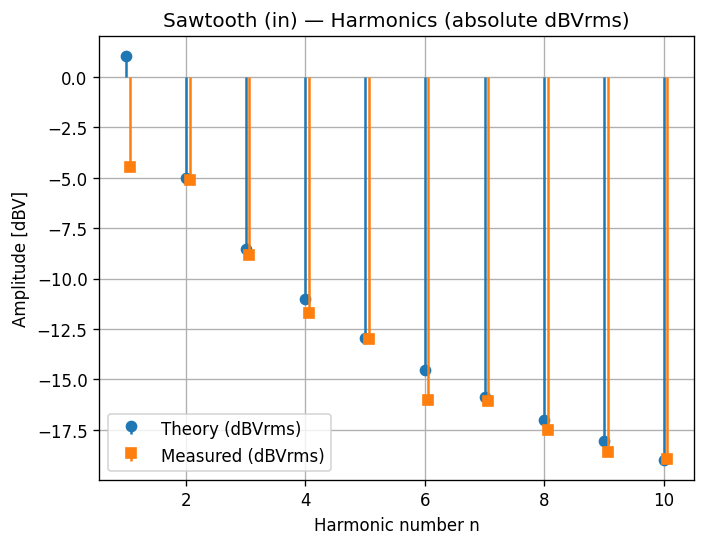

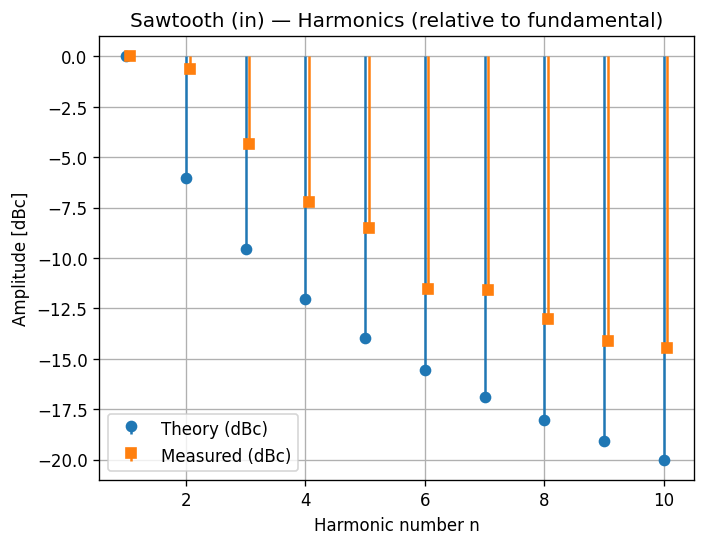

,n,f_target,i_bin,f_bin,meas_Vrms,meas_dBV,f_Hz,theory_Vrms,theory_dBV,theory_dBc,meas_dBc,err_abs_dB,err_rel_dB
0,1,1000.0,997,1000.40,0.596875,-4.48,1000.0,1.125395,1.03,0.00,0.00,-5.51,0.00
1,2,2000.0,2045,1999.86,0.554492,-5.12,2000.0,0.562698,-4.99,-6.02,-0.64,-0.13,5.38
2,3,3000.0,3094,3000.26,0.361133,-8.85,3000.0,0.375132,-8.52,-9.54,-4.36,-0.33,5.18
3,4,4000.0,4142,3999.71,0.259766,-11.71,4000.0,0.281349,-11.02,-12.04,-7.23,-0.69,4.82
4,5,5000.0,5191,5000.11,0.224219,-12.99,5000.0,0.225079,-12.95,-13.98,-8.50,-0.03,5.48
5,6,6000.0,6239,5999.57,0.157813,-16.04,6000.0,0.187566,-14.54,-15.56,-11.55,-1.50,4.01
6,7,7000.0,7288,6999.97,0.157227,-16.07,7000.0,0.160771,-15.88,-16.90,-11.59,-0.19,5.31
7,8,8000.0,8337,8000.37,0.133203,-17.51,8000.0,0.140674,-17.04,-18.06,-13.03,-0.47,5.03
8,9,9000.0,9385,8999.82,0.117383,-18.61,9000.0,0.125044,-18.06,-19.08,-14.13,-0.55,4.96
9,10,10000.0,10434,10000.23,0.113086,-18.93,10000.0,0.112540,-18.97,-20.00,-14.45,0.04,5.55


In [66]:
# ===================== EXAMPLE CALL =====================
#Use your *raw* file with the overhead & semicolons & decimal commas:
csv_raw = "trace_saw_fft.csv"   # <-- update path if needed
df_saw = analyze_keysight_raw(csv_raw, F0=F0, N_HARM=N_HARM,
                              waveform='saw', apply_rc_to_theory=False,
                               title_prefix="Sawtooth (in)")
display(df_saw.round({'f_target':2,'f_bin':2,'meas_Vrms':6,'meas_dBV':2,'theory_Vrms':6,
                      'theory_dBV':2,'meas_dBc':2,'theory_dBc':2,'err_abs_dB':2,'err_rel_dB':2}))


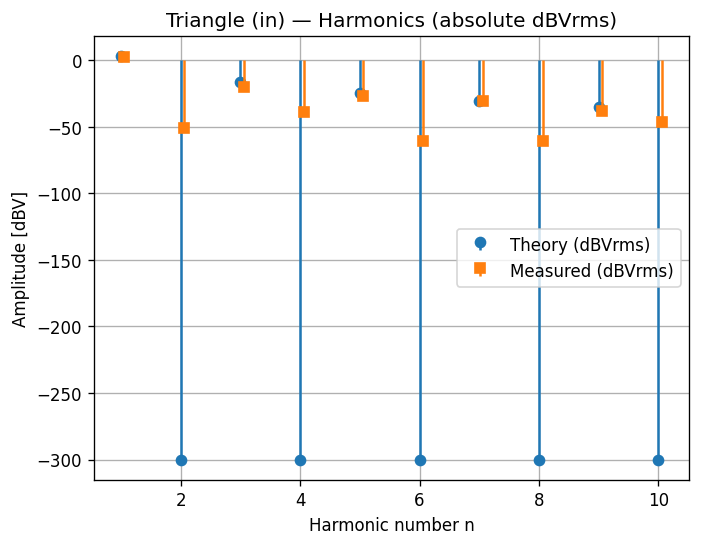

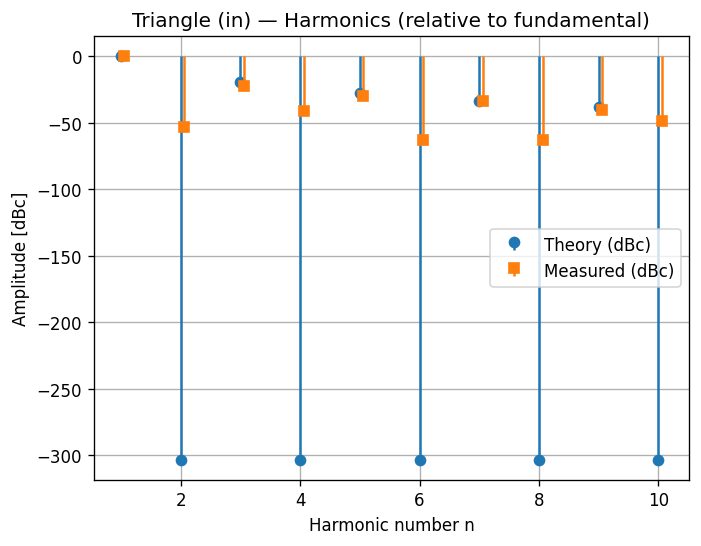

,n,f_target,i_bin,f_bin,meas_Vrms,meas_dBV,f_Hz,theory_Vrms,theory_dBV,theory_dBc,meas_dBc,err_abs_dB,err_rel_dB
0,1,1000.0,2,999.45,1.355469,2.64,1000.0,1.432898,3.12,0.00,0.00,-0.48,0.00
1,2,2000.0,6,1998.90,0.002930,-50.66,2000.0,0.000000,-300.00,-303.12,-53.31,249.34,249.82
2,3,3000.0,9,2998.35,0.099609,-20.03,3000.0,0.159211,-15.96,-19.08,-22.68,-4.07,-3.59
3,4,4000.0,11,4997.25,0.011719,-38.62,4000.0,0.000000,-300.00,-303.12,-41.26,261.38,261.86
4,5,5000.0,12,5001.07,0.044922,-26.95,5000.0,0.057316,-24.83,-27.96,-29.59,-2.12,-1.63
5,6,6000.0,13,5004.88,0.000976,-60.21,6000.0,0.000000,-300.00,-303.12,-62.85,239.79,240.27
6,7,7000.0,14,6999.97,0.029297,-30.66,7000.0,0.029243,-30.68,-33.80,-33.31,0.02,0.50
7,8,8000.0,15,7003.78,0.000976,-60.21,8000.0,0.000000,-300.00,-303.12,-62.85,239.79,240.27
8,9,9000.0,16,8998.87,0.012695,-37.93,9000.0,0.017690,-35.05,-38.17,-40.57,-2.88,-2.40
9,10,10000.0,17,9002.69,0.004883,-46.23,10000.0,0.000000,-300.00,-303.12,-48.87,253.77,254.26


In [67]:
# ===================== TRIANGLE & SINE – EXAMPLE CALLS =====================

# 1) Triangle (in)
csv_tri = "trace_triangle_fft.csv"   # <-- ändra till din fil
df_tri = analyze_keysight_raw(csv_tri, F0=F0, N_HARM=N_HARM,
                              waveform='tri', apply_rc_to_theory=False,
                              title_prefix="Triangle (in)")
display(df_tri.round({'f_target':2,'f_bin':2,'meas_Vrms':6,'meas_dBV':2,'theory_Vrms':6,
                      'theory_dBV':2,'meas_dBc':2,'theory_dBc':2,'err_abs_dB':2,'err_rel_dB':2}))


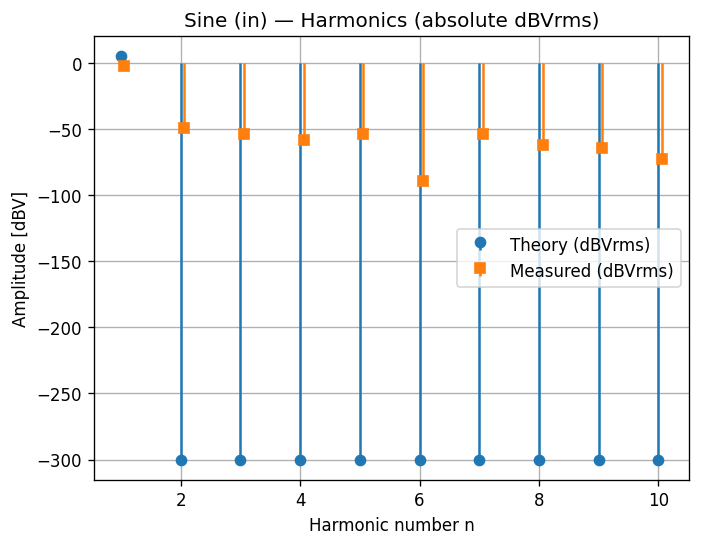

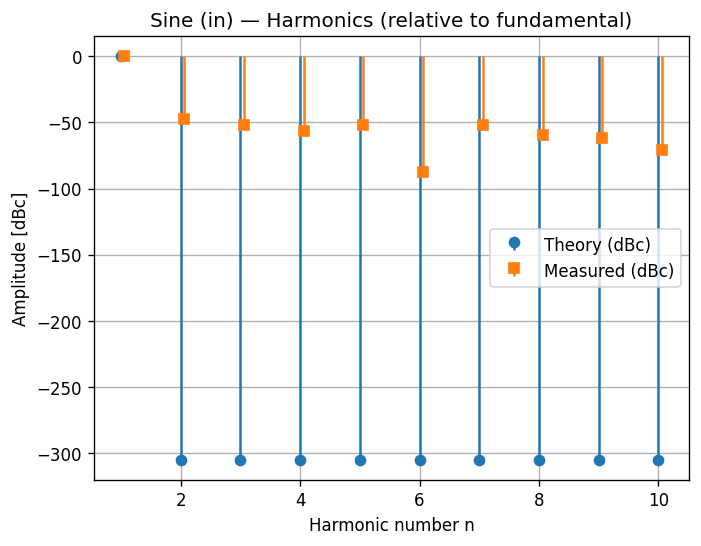

,n,f_target,i_bin,f_bin,meas_Vrms,meas_dBV,f_Hz,theory_Vrms,theory_dBV,theory_dBc,meas_dBc,err_abs_dB,err_rel_dB
0,1,1000.0,1027,1000.40,0.784995,-2.10,1000.0,1.767767,4.95,0.00,0.00,-7.05,0.00
1,2,2000.0,2064,1999.86,0.003354,-49.49,2000.0,0.000000,-300.00,-304.95,-47.38,250.51,257.56
2,3,3000.0,3090,3000.26,0.001987,-54.04,3000.0,0.000000,-300.00,-304.95,-51.93,245.96,253.02
3,4,4000.0,4123,3999.71,0.001206,-58.37,4000.0,0.000000,-300.00,-304.95,-56.27,241.63,248.68
4,5,5000.0,5153,5000.11,0.001987,-54.04,5000.0,0.000000,-300.00,-304.95,-51.93,245.96,253.02
5,6,6000.0,6183,5999.57,0.000034,-89.34,6000.0,0.000000,-300.00,-304.95,-87.24,210.66,217.71
6,7,7000.0,7217,6999.97,0.001987,-54.04,7000.0,0.000000,-300.00,-304.95,-51.93,245.96,253.02
7,8,8000.0,8249,8000.37,0.000815,-61.77,8000.0,0.000000,-300.00,-304.95,-59.67,238.23,245.28
8,9,9000.0,9280,8999.82,0.000620,-64.15,9000.0,0.000000,-300.00,-304.95,-62.05,235.85,242.90
9,10,10000.0,10310,10000.23,0.000229,-72.79,10000.0,0.000000,-300.00,-304.95,-70.68,227.21,234.26


In [68]:
# 2) Sine (in)
csv_sin = "trace_sine_fft.csv"   # <-- ändra till din fil
df_sin = analyze_keysight_raw(csv_sin, F0=F0, N_HARM=N_HARM,
                              waveform='sin', apply_rc_to_theory=False,
                              title_prefix="Sine (in)")
display(df_sin.round({'f_target':2,'f_bin':2,'meas_Vrms':6,'meas_dBV':2,'theory_Vrms':6,
                      'theory_dBV':2,'meas_dBc':2,'theory_dBc':2,'err_abs_dB':2,'err_rel_dB':2}))

# (Valfritt) Sågtand efter RC – om du har separat CSV mätt efter filtret
# csv_saw_rc = "trace_saw_fft afterRC 0.csv"  # <-- ändra till din fil
# df_saw_rc = analyze_keysight_raw(csv_saw_rc, F0=F0, N_HARM=N_HARM,
#                                  waveform='saw', apply_rc_to_theory=True,
#                                  title_prefix="Sawtooth (after RC)")
# display(df_saw_rc.round({'f_target':2,'f_bin':2,'meas_Vrms':6,'meas_dBV':2,'theory_Vrms':6,
#                          'theory_dBV':2,'meas_dBc':2,'theory_dBc':2,'err_abs_dB':2,'err_rel_dB':2}))

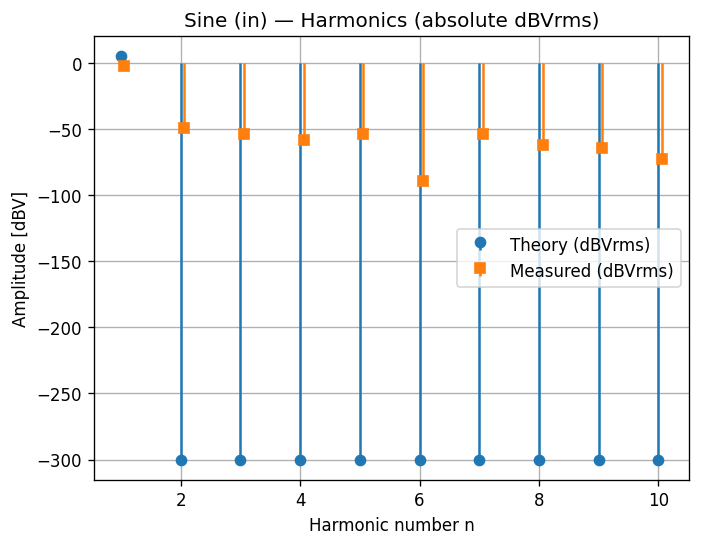

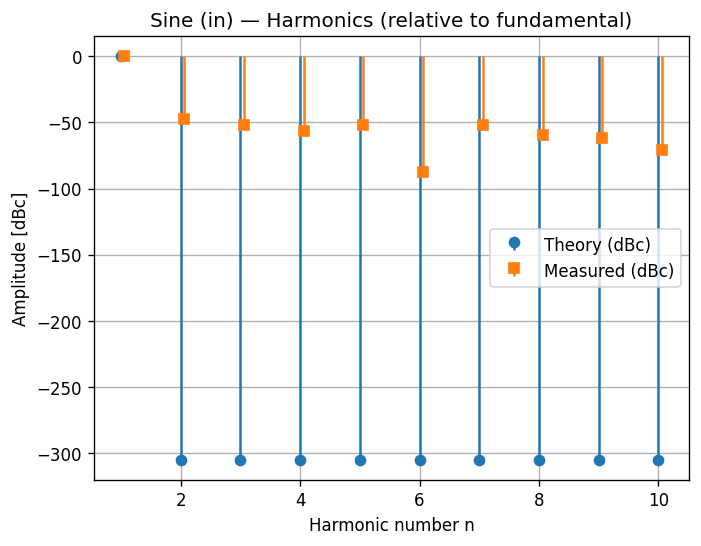

,n,f_target,i_bin,f_bin,meas_Vrms,meas_dBV,f_Hz,theory_Vrms,theory_dBV,theory_dBc,meas_dBc,err_abs_dB,err_rel_dB
0,1,1000.0,1027,1000.40,0.784995,-2.10,1000.0,1.767767,4.95,0.00,0.00,-7.05,0.00
1,2,2000.0,2064,1999.86,0.003354,-49.49,2000.0,0.000000,-300.00,-304.95,-47.38,250.51,257.56
2,3,3000.0,3090,3000.26,0.001987,-54.04,3000.0,0.000000,-300.00,-304.95,-51.93,245.96,253.02
3,4,4000.0,4123,3999.71,0.001206,-58.37,4000.0,0.000000,-300.00,-304.95,-56.27,241.63,248.68
4,5,5000.0,5153,5000.11,0.001987,-54.04,5000.0,0.000000,-300.00,-304.95,-51.93,245.96,253.02
5,6,6000.0,6183,5999.57,0.000034,-89.34,6000.0,0.000000,-300.00,-304.95,-87.24,210.66,217.71
6,7,7000.0,7217,6999.97,0.001987,-54.04,7000.0,0.000000,-300.00,-304.95,-51.93,245.96,253.02
7,8,8000.0,8249,8000.37,0.000815,-61.77,8000.0,0.000000,-300.00,-304.95,-59.67,238.23,245.28
8,9,9000.0,9280,8999.82,0.000620,-64.15,9000.0,0.000000,-300.00,-304.95,-62.05,235.85,242.90
9,10,10000.0,10310,10000.23,0.000229,-72.79,10000.0,0.000000,-300.00,-304.95,-70.68,227.21,234.26


In [69]:
# 2) Sine (in)
csv_sin = "trace_sine_fft.csv"   # <-- ändra till din fil
df_sin = analyze_keysight_raw(csv_sin, F0=F0, N_HARM=N_HARM,
                              waveform='sin', apply_rc_to_theory=False,
                              title_prefix="Sine (in)")
display(df_sin.round({'f_target':2,'f_bin':2,'meas_Vrms':6,'meas_dBV':2,'theory_Vrms':6,
                      'theory_dBV':2,'meas_dBc':2,'theory_dBc':2,'err_abs_dB':2,'err_rel_dB':2}))


### Representative Time- and Frequency-Domain Figures

Below are the captured oscilloscope time traces and FFT spectra for the three input waveforms and the RC filter behavior. Filenames correspond to the raw image assets in the repository. They serve as visual evidence supporting the quantitative tables and plots generated above.

#### Time-Domain Waveforms (Input Signals)
| Waveform | Image |
|----------|-------|
| Sawtooth | ![Sawtooth time-domain](saw_signal.png) |
| Triangle | ![Triangle time-domain](triangle_signal.png) |
| Sine     | ![Sine time-domain](sine_signal.png) |
| After RC (filtered sawtooth example) | ![RC output time-domain](rc_signal.png) |

#### FFT Spectra (Measured)
| Waveform | Image |
|----------|-------|
| Sawtooth | ![Sawtooth FFT](saw_fft.png) |
| Triangle | ![Triangle FFT](triangle_fft.png) |
| Sine     | ![Sine FFT](sine_fft.png) |

#### RC Filter Frequency Response / Effect (Selected Frequencies)
These images illustrate amplitude reduction as input frequency increases relative to the cutoff \(f_c \approx 1.94\,\text{kHz}\).

| Condition | Image |
|-----------|-------|
| 1 kHz region (near fundamental) | ![RC response ~1 kHz](rc_fft_1khz.png) |
| 10 kHz region (> octave above \(f_c\)) | ![RC response ~10 kHz](rc_fft_10khz.png) |
| 100 kHz region (well above \(f_c\)) | ![RC response ~100 kHz](rc_fft_100khz.png) |

(Additional views) Example higher‑frequency time traces illustrating stronger attenuation:

| Time Trace | Image |
|------------|-------|
| 10 kHz time-domain | ![RC time-domain 10 kHz](rc_10khz.png) |
| 100 kHz time-domain | ![RC time-domain 100 kHz](rc_100khz.png) |

> Note: If any image fails to render in exported PDF, ensure the images reside in the same directory as this notebook before conversion or embed them as base64 within the notebook.

## 5. Results (summary)
- **Sawtooth:** Harmonics up to 10 kHz visible; amplitudes decay ≈ 1/n.
- **Triangle:** Odd harmonics only; amplitudes decay ≈ 1/n².
- **Sine:** Only the fundamental ideally; extra small peaks in practice stem from leakage/noise/distortion.
- **RC filter:** Attenuation increases with frequency (≈ −20 dB/dec above \(f_c\)); phase tends to −90°. The time waveform becomes smoother.

## 6. Discussion
- **Sawtooth vs Triangle:** Sawtooth contains all harmonics (1/n); triangle only odd harmonics with faster decay (1/n²). This reflects sharp edges vs smoother ramps.
- **Sine:** Ideally only one spectral line; extra lines indicate window leakage, noise floor, or source distortion.
- **RC filter:** The predicted attenuation \(20\log_{10}|H|\) matches the trend you should observe. Deviations arise from probe loading, FFT bin resolution, window choice, and vertical scaling in dBVrms.
- **Phase:** The increasing negative phase with frequency explains the smoothing in time domain (harmonics lag more than the fundamental).

## 7. Conclusions
- Fourier series predictions for sawtooth, triangle, and sine match the expected spectral trends and harmonic content.
- The RC low-pass attenuates higher harmonics as predicted, yielding a smoother output waveform.
- Remaining differences are consistent with practical measurement limitations and FFT parameter choices.

## References
- H. Hallenberg, *Signalbehandling och kommunikationssystem*, Yrgo, 2021.
- ELA24 – *Laboration: Frekvensanalys* (Lab PM) and *Ledning Fourierlabben* (guidance notes).
- Keysight/Tektronix oscilloscope FFT documentation (Hann window, dBVrms scaling).
- Standard RC low-pass theory (jω method, Bode magnitude/phase).